In [18]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pylab as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
data = pd.read_pickle('data.bin')
data_by_categories = data.groupby('PRODUCT_CATEGORY')
categories = data_by_categories.groups.keys()
data_on_test_category = data_by_categories.get_group('047-005')
sales_on_category = data_on_test_category.groupby('WEEK').ACTUAL.sum()

In [3]:
def remove_outliers(series,factor=3):
    return series[(series-series.mean())<factor*series.std()]

In [4]:
sales_on_category = remove_outliers(sales_on_category)

In [5]:
resampled_sales = sales_on_category.resample('7d').interpolate()

In [6]:
decomposition = seasonal_decompose(resampled_sales)

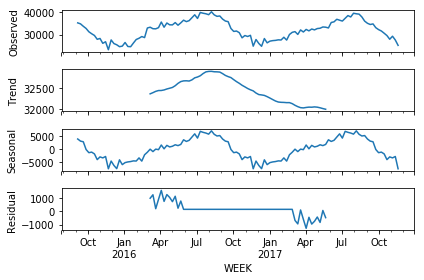

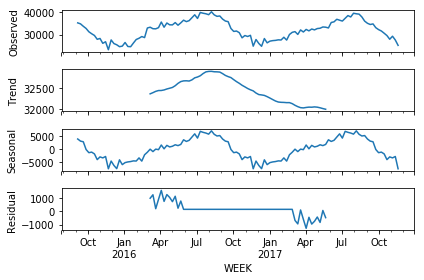

In [7]:
decomposition.plot()

D:\Programs\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


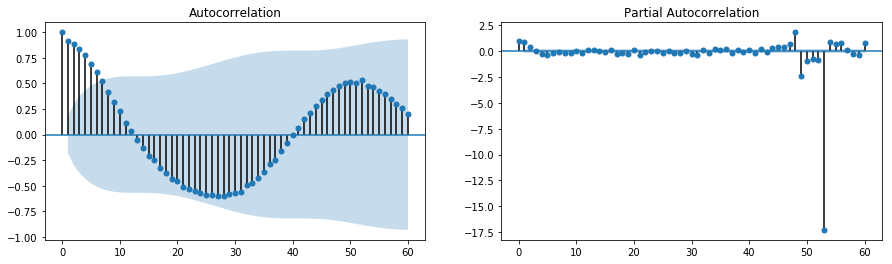

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(decomposition.seasonal, lags=60, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(decomposition.seasonal, lags=60, ax=axes[1])

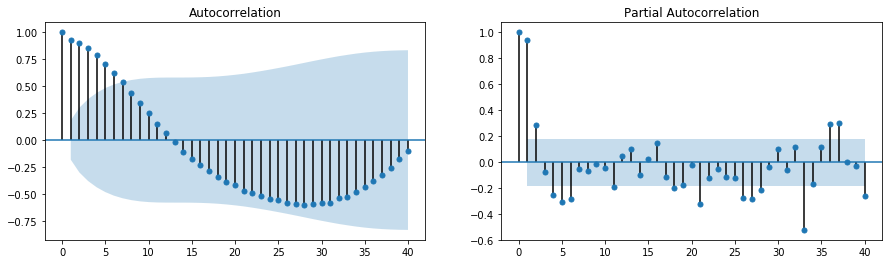

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(resampled_sales, lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(resampled_sales, lags=40, ax=axes[1])

In [21]:
model = SARIMAX(resampled_sales[0:int(len(resampled_sales)*1)],trend = 'c', order = (1,1,0),seasonal_order=(1,1,0,52))
fitted = model.fit()
prediction = fitted.predict(start=1,end=int(len(resampled_sales)*1.5))
orig = plt.plot(resampled_sales, color='blue',label='Original')
predict = plt.plot(prediction, color='black', label = 'Prediction')
plt.legend(loc='best')
plt.show(block=False)

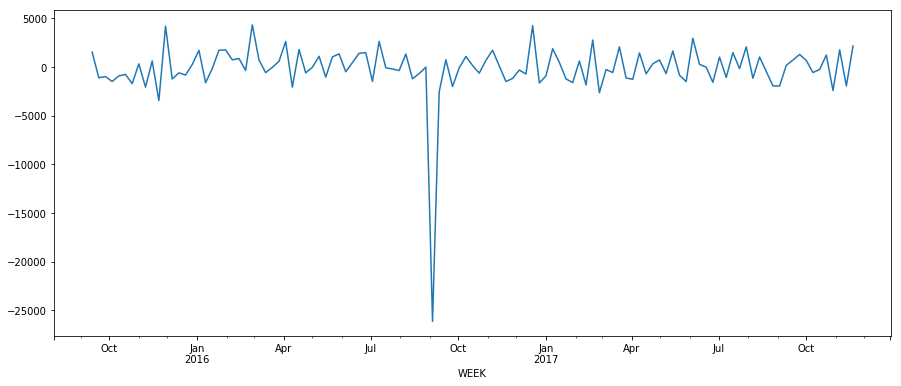

In [22]:
model_residuals = resampled_sales[1:]-prediction[0:len(resampled_sales)-1]
model_residuals.plot()

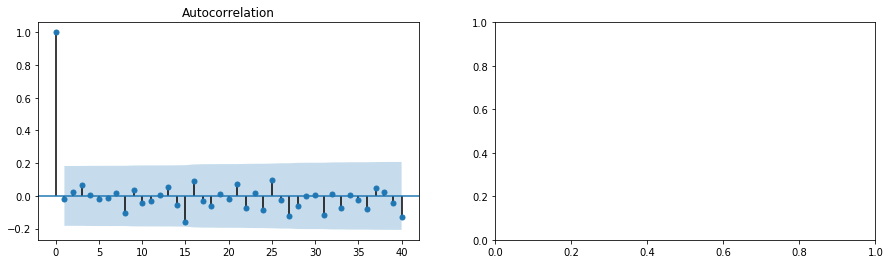

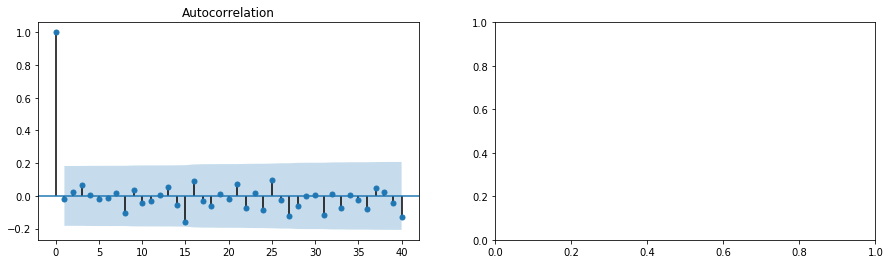

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))
sm.graphics.tsa.plot_acf(model_residuals, lags=40, ax=axes[0])

In [19]:
stepwise_fit = pm.auto_arima(resampled_sales, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=52,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=1107.793, BIC=1112.079, Fit time=0.184 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=1106.167, BIC=1114.739, Fit time=8.510 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=1107.906, BIC=1114.335, Fit time=0.483 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=1106.981, BIC=1113.410, Fit time=2.003 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=1108.654, BIC=1119.369, Fit

In [20]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  116
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood                -549.083
Date:                            Thu, 10 Jan 2019   AIC                           1106.167
Time:                                    12:31:35   BIC                           1114.739
Sample:                                         0   HQIC                          1109.538
                                            - 116                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -71.5713    204.620     -0.350      0.727    -472.619     329.476
ar.L1         -0.1045      0.040     -2.602      0.009      -0.183      -0.026
ar.S.L52      -0.1047      0.048     -2.182      0.029      -0.199      -0.011
sigma2      2.107e+06   4.25e+05      4.961      0.000    1.27e+06    2.94e+06
===================================================================================
Ljung-Box (Q):                       42.84   Jarque-Bera (JB):                 1.92
Prob(Q):                              0.35   Prob(JB):                         0.38
Heteroskedasticity (H):               0.82   Skew:                             0.41
Prob(H) (two-sided):                  0.66   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""